In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid") 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import math

In [101]:
msft_hist = pd.read_csv('../dataset/msft_2y.csv', parse_dates=True,index_col=0)

In [102]:
print(msft_hist.isnull().values.any())

False


Text(0.5, 0, 'Year')

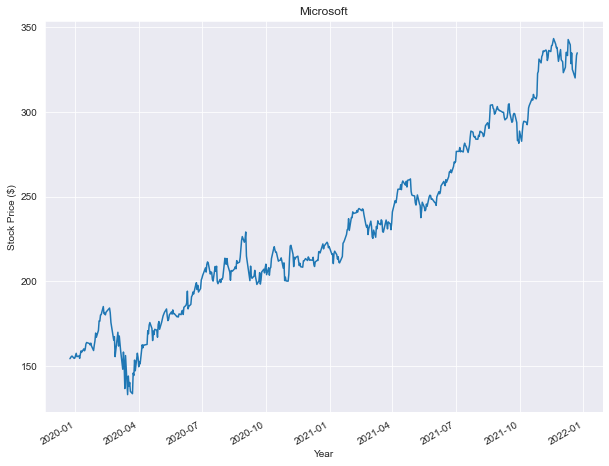

In [103]:

msft_hist['Close'].plot(figsize = (10,8))
plt.title('Microsoft')
plt.ylabel('Stock Price ($)')
plt.xlabel('Year')

In [104]:
msft_close = msft_hist[['Close']]
msft_close.info()
msft_close[['Close']]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2019-12-24 to 2021-12-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   505 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


,Close
Date,
2019-12-24,154.435745
2019-12-26,155.701584
2019-12-27,155.986160
2019-12-30,154.641800
2019-12-31,154.749725
...,...
2021-12-17,323.799988
2021-12-20,319.910004
2021-12-21,327.290009


In [105]:
scaler = MinMaxScaler(feature_range= (-1,1))

def split_data(stock, look_back):
    data_raw = stock.to_numpy()
    
    test_size = int(np.round(0.2 * data_raw.shape[0]))
    train_size = data_raw.shape[0] - test_size
    train_set = data_raw[:train_size]
    test_set = data_raw[train_size:]
    train_set_scaled = scaler.fit_transform(train_set)
    test_set_scaled = scaler.transform(test_set)

    train_data = []
    test_data = []

    for i in range(len(train_set_scaled) - look_back):
        train_data.append(train_set_scaled[i: i + look_back])
    train_data = np.array(train_data)

    for i in range(len(test_set_scaled) - look_back):
        test_data.append(test_set_scaled[i: i + look_back])
    test_data = np.array(test_data)

    x_train = train_data[:, :-1, :]
    y_train = train_data[:, -1, :] #every 60th elements affected by previous 59 elements

    x_test = test_data[:, :-1]
    y_test = test_data[:, -1, :]

    return x_train, y_train, x_test, y_test

look_back = 60
x_train, y_train, x_test, y_test = split_data(msft_close, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (344, 59, 1)
y_train.shape =  (344, 1)
x_test.shape =  (41, 59, 1)
y_test.shape =  (41, 1)


In [106]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [107]:
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100

In [108]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)    
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [109]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [110]:
hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)    
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    

Epoch  0 MSE:  0.19781474769115448
Epoch  1 MSE:  0.18990883231163025
Epoch  2 MSE:  0.18239624798297882
Epoch  3 MSE:  0.17525210976600647
Epoch  4 MSE:  0.16844850778579712
Epoch  5 MSE:  0.16195854544639587
Epoch  6 MSE:  0.1557566374540329
Epoch  7 MSE:  0.14981885254383087
Epoch  8 MSE:  0.14412404596805573
Epoch  9 MSE:  0.1386553794145584
Epoch  10 MSE:  0.13340038061141968
Epoch  11 MSE:  0.12835067510604858
Epoch  12 MSE:  0.1235005334019661
Epoch  13 MSE:  0.11884428560733795
Epoch  14 MSE:  0.11437143385410309
Epoch  15 MSE:  0.11005844920873642
Epoch  16 MSE:  0.10585761815309525
Epoch  17 MSE:  0.10168654471635818
Epoch  18 MSE:  0.0974249392747879
Epoch  19 MSE:  0.09292345494031906
Epoch  20 MSE:  0.08802337199449539
Epoch  21 MSE:  0.08258333802223206
Epoch  22 MSE:  0.07651009410619736
Epoch  23 MSE:  0.069789357483387
Epoch  24 MSE:  0.06250953674316406
Epoch  25 MSE:  0.05487055703997612
Epoch  26 MSE:  0.04717613384127617
Epoch  27 MSE:  0.0398205891251564
Epoch  28

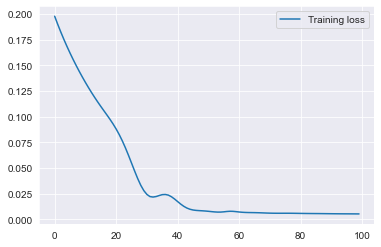

In [111]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [112]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.69 RMSE
Test Score: 17.91 RMSE


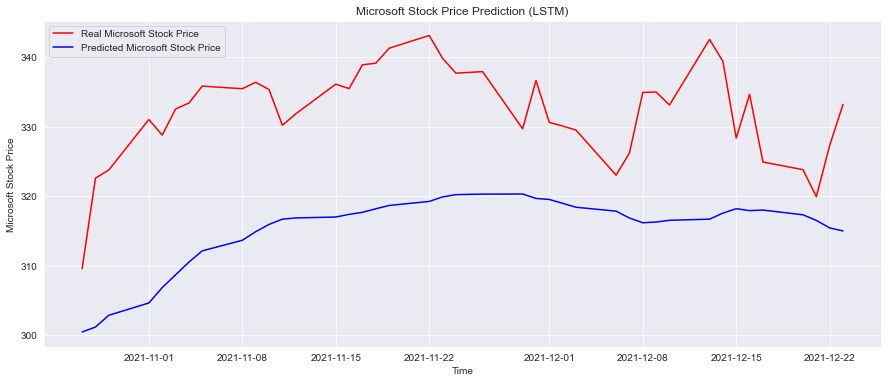

In [113]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(msft_close[len(msft_close)-len(y_test):].index, y_test, color = 'red', label = 'Real Microsoft Stock Price')
axes.plot(msft_close[len(msft_close)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Microsoft Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Microsoft Stock Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
# plt.savefig('ibm_pred.png')
plt.show()